![banner](./data/home-sales-shutterstock-295804091-1068x601.jpg)

# King County Home Sales
**Authors:** [Jerry Vasquez](https://www.linkedin.com/in/jerry-vasquez-832b71224/), [Paul Lindquist](https://www.linkedin.com/in/paul-lindquist/), [Vu Brown](https://www.linkedin.com/in/austin-brown-b5211384/)

## Overview
***
This project assumes that we work for a real estate company in King County, Washington. We're tasked with providing data-driven recommendations for buying and selling homes.

## Business Problem
***
The company wants recommendations for customers looking to buy a home and for customers looking to sell their home.

As such, recommendations will be divided into 2 categories: buying homes and selling homes.

Buying homes:
- Use housing data (comps) of recently sold homes to create an inferential model
    - Model will be built using linear regression and selected variables (features) that best work with the target (price)
- Use the inferential model to assess what houses are underpriced or overpriced for customers looking to buy a home

Selling homes:
- Build a predictive model using comps of recently sold homes
    - Model will also be built using linear regression but use a more wholistic approach with features that could possibly add additional value
- Use the predictive model to recommend what price should be assigned to homes that will be sold by the company

## Data
***
This project uses the King County House Sales dataset, which can be found [here](https://www.kaggle.com/harlfoxem/housesalesprediction).

## Methods
***
We'll conduct descriptive analysis, linear regression and modeling (inferential, predictive).

## Exploratory Data Analysis
***
Investigating the data to look for correlations, outliers/anomalies and patterns. Providing summary statistics and visualizations.

In [212]:
# Import libraries
import pandas as pd
import numpy as np
from math import sqrt
import time
from collections import Counter
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(palette='magma_r')
import plotly.express as px
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 100) # Allows Jupyter Notebook to expand how much data is shown.

In [2]:
# Load DataFrame
df = pd.read_csv('./data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.shape

(21597, 21)

In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
df.nunique(axis=0)

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

In [8]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4580474287.770987,540296.573506,3.373200,2.115826,2080.321850,15099.408760,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2876735715.747780,367368.140101,0.926299,0.768984,918.106125,41412.636876,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1000102.000000,78000.000000,1.000000,0.500000,370.000000,520.000000,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2123049175.000000,322000.000000,3.000000,1.750000,1430.000000,5040.000000,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3904930410.000000,450000.000000,3.000000,2.250000,1910.000000,7618.000000,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7308900490.000000,645000.000000,4.000000,2.500000,2550.000000,10685.000000,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9900000190.000000,7700000.000000,33.000000,8.000000,13540.000000,1651359.000000,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [9]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


In [10]:
# Features with highest correlation to price
price_corr = df.corr()['price'].map(abs).sort_values(ascending=False)
price_corr

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
floors           0.256804
yr_renovated     0.129599
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
zipcode          0.053402
long             0.022036
id               0.016772
Name: price, dtype: float64

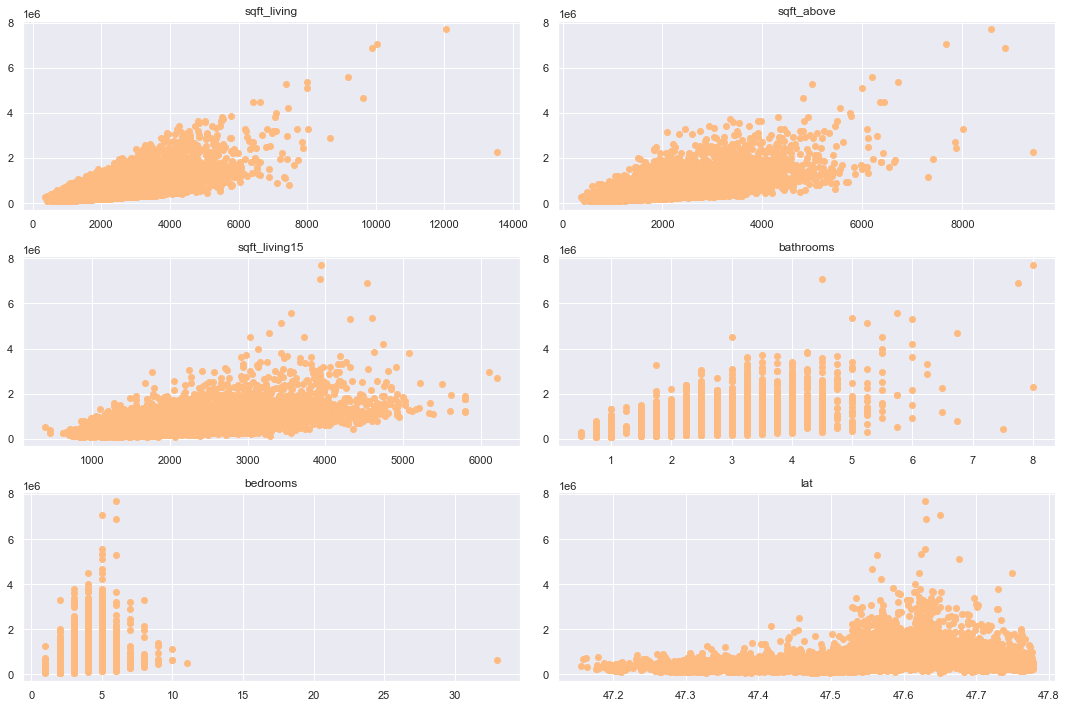

In [11]:
# Plot top 6 feature correlations with price
fig, axs = plt.subplots(3, 2, figsize=(15,10))
axs[0, 0].scatter(df.sqft_living, df.price)
axs[0, 0].set_title('sqft_living')
axs[0, 1].scatter(df.sqft_above, df.price)
axs[0, 1].set_title('sqft_above')
axs[1, 0].scatter(df.sqft_living15, df.price)
axs[1, 0].set_title('sqft_living15')
axs[1, 1].scatter(df.bathrooms, df.price)
axs[1, 1].set_title('bathrooms')
axs[2, 0].scatter(df.bedrooms, df.price)
axs[2, 0].set_title('bedrooms')
axs[2, 1].scatter(df.lat, df.price)
axs[2, 1].set_title('lat')
fig.tight_layout();

In [83]:
# Plot the latitude and longitude coordinates to examine where home prices are
# the highest
df_minus_outliers = df[df.price < (df.price.mean() + 3*df.price.std())].copy()

fig = px.scatter_mapbox(df_minus_outliers, lat="lat", lon="long", color="price",
                        color_discrete_sequence=["IceFire"], zoom=10.2, height=1000)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Data Cleaning, Preparation, Feature Engineering, etc.
***
Identifying and dropping duplicates

In [13]:
# Create a function to identify duplicates
def determine_dupes(series):
    series_vcs = pd.Series(series.value_counts())
    series_dupes = [series_vcs.index[index] for index in range(len(series_vcs)) if series_vcs.values[index] > 1]
    print("Amount of unique duplicates: " + str(len(series_dupes)))
    print("Total amount of duplicates: " + str(series_vcs.values[0:len(series_dupes)].sum()))
    
    return series_vcs

In [14]:
# Run duplicates function for 'id' series
determine_dupes(df.id)

Amount of unique duplicates: 176
Total amount of duplicates: 353


795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [15]:
# display(df.loc[df.id == 795000620])
# display(df[df.duplicated(subset=['id'], keep=False)].head(20))
# display(df[df.duplicated(subset=['id'], keep='first')].head(10))

In [16]:
# Drop duplicates found within 'id' series
df = df.drop_duplicates(subset=['id'], keep='last')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   date           21420 non-null  object 
 2   price          21420 non-null  float64
 3   bedrooms       21420 non-null  int64  
 4   bathrooms      21420 non-null  float64
 5   sqft_living    21420 non-null  int64  
 6   sqft_lot       21420 non-null  int64  
 7   floors         21420 non-null  float64
 8   waterfront     19067 non-null  object 
 9   view           21357 non-null  object 
 10  condition      21420 non-null  object 
 11  grade          21420 non-null  object 
 12  sqft_above     21420 non-null  int64  
 13  sqft_basement  21420 non-null  object 
 14  yr_built       21420 non-null  int64  
 15  yr_renovated   17607 non-null  float64
 16  zipcode        21420 non-null  int64  
 17  lat            21420 non-null  float64
 18  long  

In [17]:
# df[df.duplicated(subset=['lat','long'], keep=False)].sort_values('lat')
# df = df.drop_duplicates(subset=['lat', 'long'], keep='last')

Identify and drop outliers

In [18]:
# Examine number of bedrooms for outliers
df.bedrooms.value_counts()

3     9731
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [19]:
# df.loc[df.bedrooms == 8].sort_values('sqft_living', ascending=False).head(20)

In [20]:
# 33 bedrooms for a 1620 sqft house is a mistake. We'll drop those values.
# 9, 10 & 11 bedrooms for houses under 5000 sqft are also a mistake. We'll drop.
df.drop(df.loc[df['bedrooms']==33].index, inplace=True)
df.drop(df.loc[df['bedrooms']==11].index, inplace=True)
df.drop(df.loc[df['bedrooms']==10].index, inplace=True)
df.drop(df.loc[df['bedrooms']==9].index, inplace=True)

df.sort_values('bedrooms', ascending=False).head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10946,1652500060,7/11/2014,1650000.0,8,2.75,4040,20666,1.0,NO,NONE,...,9 Better,2020,2020.0,1962,0.0,98004,47.6340,-122.221,3670,20500
12872,8813400155,12/19/2014,808000.0,8,3.75,3460,4600,2.0,NO,NONE,...,7 Average,2860,600.0,1987,0.0,98105,47.6617,-122.289,2170,3750
17221,1338600225,5/28/2014,1970000.0,8,3.50,4440,6480,2.0,NO,GOOD,...,10 Very Good,3140,1300.0,1959,0.0,98112,47.6310,-122.303,4440,8640
15656,8141200080,8/14/2014,680000.0,8,2.75,2530,4800,2.0,NO,NONE,...,7 Average,1390,1140.0,1901,NaN,98112,47.6241,-122.305,1540,4800
1658,9126101740,12/4/2014,490000.0,8,5.00,2800,2580,2.0,NO,NONE,...,8 Good,1880,920.0,1997,0.0,98122,47.6086,-122.303,1800,2580
9068,6746700615,3/18/2015,700000.0,8,2.50,2280,3000,1.5,NO,NONE,...,7 Average,1210,1070.0,1911,0.0,98105,47.6675,-122.316,1610,3000
4031,685000115,10/7/2014,2150000.0,8,6.00,4340,9415,2.0,NO,NONE,...,8 Good,4340,0.0,1967,0.0,98004,47.6316,-122.202,2050,9100
4063,7226500100,2/19/2015,373000.0,8,3.00,2850,12714,1.0,NaN,NONE,...,7 Average,2850,0.0,1959,0.0,98055,47.4859,-122.205,1480,4942
6168,1873400020,7/3/2014,340000.0,8,2.75,2790,6695,1.0,NaN,NONE,...,7 Average,1470,1320.0,1977,NaN,98133,47.7565,-122.331,1760,7624
19287,3756900027,11/25/2014,575000.0,8,3.00,3840,15990,1.0,NO,NONE,...,7 Average,2530,1310.0,1961,0.0,98034,47.7111,-122.211,1380,8172


In [21]:
# df.bathrooms.value_counts()
# df.loc[df.bathrooms == 0.5]

Make features more workable by dealing with missing/bunk values and changing series from objects to integers

In [22]:
# Replace NaN/?/missing values with 0, None or No for respective series
# Also change object series to integer via astype function
df.yr_renovated = df.yr_renovated.fillna(0)
df.yr_renovated = df.yr_renovated.astype('int64')

df.view = df.view.fillna('NONE')

df.waterfront = df.waterfront.fillna('NO')

df.loc[df.sqft_basement == '?', 'sqft_basement'] = 0.0
df.sqft_basement = df.sqft_basement.astype('float64').astype('int64')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21409 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21409 non-null  int64  
 1   date           21409 non-null  object 
 2   price          21409 non-null  float64
 3   bedrooms       21409 non-null  int64  
 4   bathrooms      21409 non-null  float64
 5   sqft_living    21409 non-null  int64  
 6   sqft_lot       21409 non-null  int64  
 7   floors         21409 non-null  float64
 8   waterfront     21409 non-null  object 
 9   view           21409 non-null  object 
 10  condition      21409 non-null  object 
 11  grade          21409 non-null  object 
 12  sqft_above     21409 non-null  int64  
 13  sqft_basement  21409 non-null  int64  
 14  yr_built       21409 non-null  int64  
 15  yr_renovated   21409 non-null  int64  
 16  zipcode        21409 non-null  int64  
 17  lat            21409 non-null  float64
 18  long  

In [24]:
# OPTION 1: sklearn - Change 'grade' series objects to integers
# lb_make = LabelEncoder()
# df['grade'] = lb_make.fit_transform(df['grade'])
# df.grade.value_counts()
# 8:Average, 9:Good, 10:Better, 7:Low Average, 0:Very Good
# 1:Excellent, 6:Fair, 2:Luxury, 5:Low, 3:Mansion, 4:Poor

In [25]:
# OPTION 2: pd.replace - Change 'grade' series objects to corresponding integers
df.grade = pd.to_numeric(df.grade.map(lambda x: x.split()[0]))
df['grade'].replace('3 Poor', 3, inplace=True)
df['grade'].replace('4 Low', 4, inplace=True)
df['grade'].replace('5 Fair', 5, inplace=True)
df['grade'].replace('6 Low Average', 6, inplace=True)
df['grade'].replace('7 Average', 7, inplace=True)
df['grade'].replace('8 Good', 8, inplace=True)
df['grade'].replace('9 Better', 9, inplace=True)
df['grade'].replace('10 Very Good', 10, inplace=True)
df['grade'].replace('11 Excellent', 11, inplace=True)
df['grade'].replace('12 Luxury', 12, inplace=True)
df['grade'].replace('13 Mansion', 13, inplace=True)
df.grade.value_counts()

7     8881
8     6040
9     2605
6     1995
10    1130
11     395
5      234
12      88
4       27
13      13
3        1
Name: grade, dtype: int64

In [26]:
# OPTION 1: sklearn - Change 'condition' series objects to integers
# lb_make = LabelEncoder()
# df['condition'] = lb_make.fit_transform(df['condition'])
# df.condition.value_counts()
# 0:Average, 2:Good, 4:Very Good 1: Fair, 3:Poor

In [27]:
# OPTION 2: pd.replace - Change 'condition' series objects to corresponding integers
# Integer values from https://info.kingcounty.gov/assessor/esales/Glossary.aspx
df['condition'].replace('Poor', 1, inplace=True)
df['condition'].replace('Fair', 2, inplace=True)
df['condition'].replace('Average', 3, inplace=True)
df['condition'].replace('Good', 4, inplace=True)
df['condition'].replace('Very Good', 5, inplace=True)
df.condition.value_counts()

3    13892
4     5641
5     1686
2      162
1       28
Name: condition, dtype: int64

In [28]:
df.waterfront.value_counts()

NO     21263
YES      146
Name: waterfront, dtype: int64

In [29]:
# OPTION 1: sklearn - Change 'waterfront' series objects to integers
# lb_make = LabelEncoder()
# df['waterfront'] = lb_make.fit_transform(df['waterfront'])
# df.waterfront.value_counts()
# 0:NO, 1:YES

In [30]:
# OPTION 2: pd.cat.codes - Change 'waterfront' series objects to category
# df.waterfront = df.waterfront.astype('category')
# df.waterfront.cat.codes
# df.waterfront.value_counts()
# 0:NO, 1:YES

In [31]:
# OPTION 3: pd.replace - Change 'waterfront' series YES/NO objects to corresponding 0/1 integers 
df['waterfront'].replace('NO', 0, inplace=True)
df['waterfront'].replace('YES', 1, inplace=True)
df.waterfront.value_counts()

0    21263
1      146
Name: waterfront, dtype: int64

In [32]:
# OPTION 1: sklearn - Change 'view' series objects to integers
# lb_make = LabelEncoder()
# df['view'] = lb_make.fit_transform(df['view'])
# df.view.value_counts()
# 4:NONE, 0:AVERAGE, 3:GOOD, 2:FAIR, 1:EXCELLENT

In [33]:
# OPTION 2: pd.replace - Change 'view' series objects to corresponding integers
# Integer values mirrored from 'condition' series
df['view'].replace('NONE', 0, inplace=True)
df['view'].replace('FAIR', 2, inplace=True)
df['view'].replace('AVERAGE', 3, inplace=True)
df['view'].replace('GOOD', 4, inplace=True)
df['view'].replace('EXCELLENT', 5, inplace=True)
df.view.value_counts()

0    19306
3      955
4      505
2      329
5      314
Name: view, dtype: int64

In [34]:
# Change 'date' series to datetime data type (may not be needed)
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21409 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21409 non-null  int64         
 1   date           21409 non-null  datetime64[ns]
 2   price          21409 non-null  float64       
 3   bedrooms       21409 non-null  int64         
 4   bathrooms      21409 non-null  float64       
 5   sqft_living    21409 non-null  int64         
 6   sqft_lot       21409 non-null  int64         
 7   floors         21409 non-null  float64       
 8   waterfront     21409 non-null  int64         
 9   view           21409 non-null  int64         
 10  condition      21409 non-null  int64         
 11  grade          21409 non-null  int64         
 12  sqft_above     21409 non-null  int64         
 13  sqft_basement  21409 non-null  int64         
 14  yr_built       21409 non-null  int64         
 15  yr_renovated   2140

## Predictive Modeling
***
In this section, we take an iterative approach to create a predictive model using many correlated features. We'll normalize and scale all of the data.

In [155]:
# Create model training and testing data
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

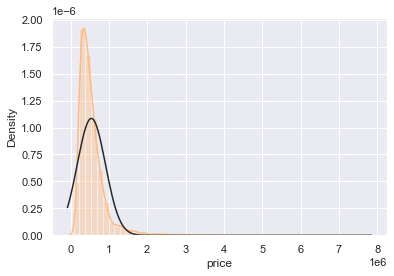

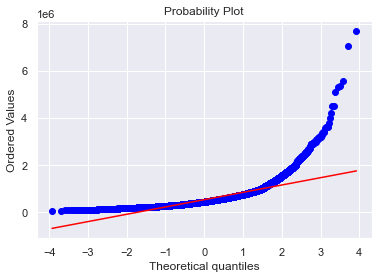

In [156]:
# Examine target ('price') distribution
sns.distplot(y_train, fit=stats.norm)
fig = plt.figure()
stats.probplot(y_train, plot=plt);

In [157]:
# Run log function to normalize target data
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

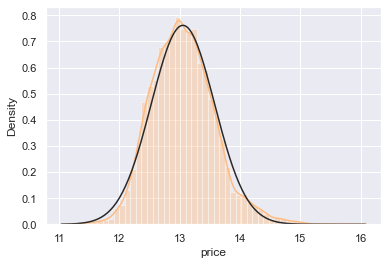

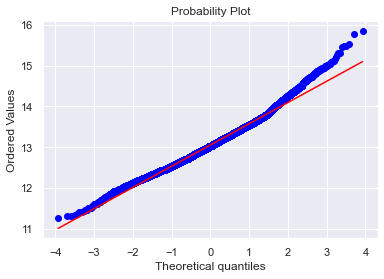

In [158]:
# Re-examine target ('price') 
sns.distplot(y_train_log, fit=stats.norm)
fig = plt.figure()
stats.probplot(y_train_log, plot=plt);

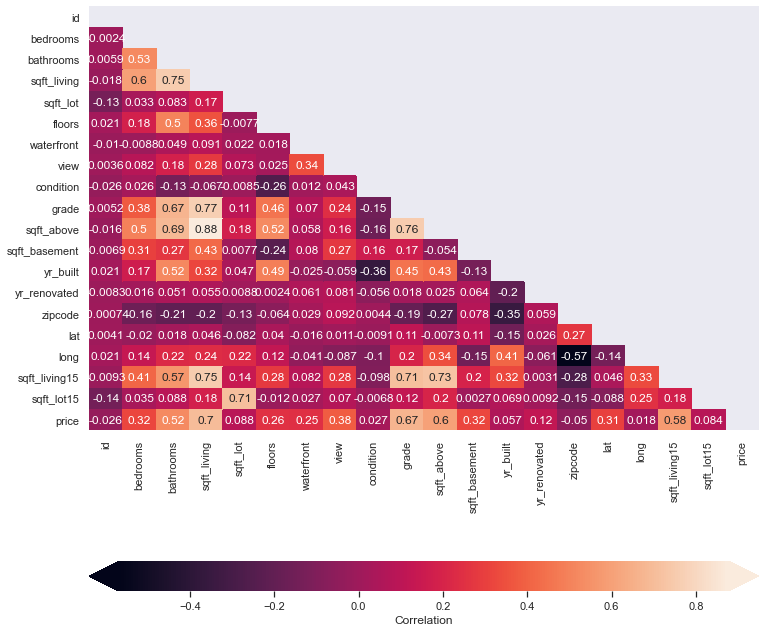

In [159]:
# Show feature correlation of training data
train_data = pd.concat([X_train, y_train], axis=1)
corr = train_data.corr()

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)),
            ax=ax,annot=True, cbar_kws={"label": "Correlation",
                                        "orientation": "horizontal",
                                        "pad": .2, "extend": "both"});

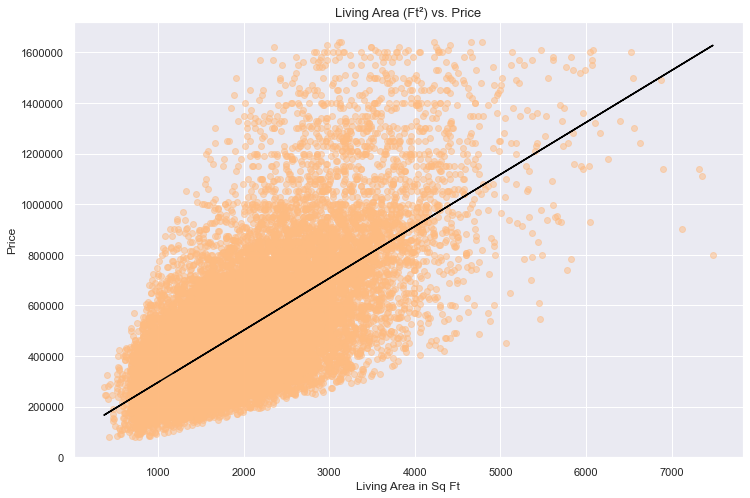

In [160]:
# Show linear correlation with 'price' & 'sqft_living'
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df_minus_outliers.sqft_living, df_minus_outliers.price, alpha=0.5)
ax.set_xlabel('Living Area in Sq Ft')
ax.set_ylabel('Price')
ax.ticklabel_format(style='plain', axis='y')
ax.set_title('Living Area (Ft²) vs. Price', fontsize=13)
m, b = np.polyfit(df_minus_outliers.sqft_living, df_minus_outliers.price, 1)
plt.plot(df_minus_outliers.sqft_living, m*df_minus_outliers.sqft_living + b, color='black');

In [161]:
# Create baseline model with DummyRegressor
baseline = DummyRegressor()
baseline.fit(X_train, y_train_log)
baseline.score(X_test, y_test_log)

-8.383878485695995e-05

In [162]:
# Run baseline model with highested correlated feature ('sqft_living')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit

first_model = LinearRegression()

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

first_scores = cross_validate(estimator=first_model,
                                 X=X_train[['sqft_living']],
                                 y=y_train_log, return_train_score=True,
                                 cv=splitter)

print('Train score: ', first_scores['train_score'].mean())
print('Validation score: ', first_scores['test_score'].mean())

Train score:  0.4856651402023873
Validation score:  0.4710822833640436


In [163]:
# Add additional, correlated features to X_train data
select_features = X_train[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                             'floors', 'waterfront', 'view', 'condition', 'grade',
                             'sqft_above', 'sqft_basement', 'sqft_living15',
                             'sqft_lot15']].copy()

In [164]:
# Run 2nd model with additional, correlated features
second_model_with_ylog = LinearRegression()

second_model_scores = cross_validate(estimator=second_model_with_ylog,
                                     X=select_features, y=y_train_log,
                                     return_train_score=True, cv=splitter)

print('Second Model')
print('Train score: ', second_model_scores['train_score'].mean())
print('Validation score: ', second_model_scores['test_score'].mean())
print()
print('First Model')
print('Train score: ', first_scores['train_score'].mean())
print('Validation score: ', first_scores['test_score'].mean())

Second Model
Train score:  0.6060248911724325
Validation score:  0.5928302214934854

First Model
Train score:  0.4856651402023873
Validation score:  0.4710822833640436


In [165]:
# Examine OLS summary table to examine coefficients
sm.OLS(y_train_log, sm.add_constant(select_features)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     1874.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:58:39   Log-Likelihood:                -4982.8
No. Observations:               16056   AIC:                             9994.
Df Residuals:                   16042   BIC:                         1.010e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.8257      0.029    369.997      0.000      10.768      10.883
bedrooms         -0.0215      0.004     -5.657      0.000      -0.029      -0.014
bathrooms        -0.0176      0.006     -3.019      0.003      -0.029      -0.006
sqft_living       0.0002    3.4e-05      6.180      0.000       0.000       0.000
sqft_lot       2.574e-07   8.73e-08      2.949      0.003    8.63e-08    4.29e-07
floors            0.0709      0.007     10.736      0.000       0.058       0.084
waterfront        0.3615      0.034     10.498      0.000       0.294       0.429
view              0.0502      0.003     17.775      0.000       0.045       0.056
condition         0.0941      0.004     22.290      0.000       0.086       0.102
grade             0.1815      0.004     45.997      0.000       0.174       0.189
sqft_above    -7.319e-05    3.4e-05     -2.156      0.031      -0.000   -6.64e-06
sqft_basement  5.219e-05   3.37e-05      1.548      0.122   -1.39e-05       0.000
sqft_living15  9.357e-05   6.31e-06     14.821      0.000    8.12e-05       0.000
sqft_lot15    -7.809e-07   1.39e-07     -5.603      0.000   -1.05e-06   -5.08e-07
==============================================================================
Omnibus:                       10.034   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.710
Skew:                           0.042   Prob(JB):                      0.00779
Kurtosis:                       2.914   Cond. No.                     6.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [166]:
# Remove 'sqft_basement' due to high p-value and possible multicollinearity
less_features = select_features.drop(['sqft_basement'], axis=1).copy()

In [167]:
#Run 3rd model with 'sqft_basement' removed
third_model_with_ylog = LinearRegression()

third_model_scores = cross_validate(estimator=third_model_with_ylog,
                                     X=less_features, y=y_train_log,
                                     return_train_score=True, cv=splitter)

print('Third Model')
print('Train score: ', third_model_scores['train_score'].mean())
print('Validation score: ', third_model_scores['test_score'].mean())
print()
print('Second Model')
print('Train score: ', second_model_scores['train_score'].mean())
print('Validation score: ', second_model_scores['test_score'].mean())
print()
print('First Model')
print('Train score: ', first_scores['train_score'].mean())
print('Validation score: ', first_scores['test_score'].mean())

Third Model
Train score:  0.6060012960573499
Validation score:  0.5928295181535929

Second Model
Train score:  0.6060248911724325
Validation score:  0.5928302214934854

First Model
Train score:  0.4856651402023873
Validation score:  0.4710822833640436


In [168]:
# Use recursive feature elimination and feature selection to examine significant features
X_train_for_RFECV = StandardScaler().fit_transform(less_features)

model_for_RFECV = LinearRegression()

selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train_log)

print("Was the column selected?")
for index, col in enumerate(less_features.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: True
floors: True
waterfront: True
view: True
condition: True
grade: True
sqft_above: True
sqft_living15: True
sqft_lot15: True


Creating a final model with the settled-on, selected features. This is also where we'll normalize (log) and scale the remaining data (independent variables).

In [169]:
final_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                  'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                  'sqft_living15', 'sqft_lot15']

In [170]:
# Build final model and score it

X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

final_model = LinearRegression()
final_model.fit(X_train_final, y_train_log)

final_model.score(X_test_final, y_test_log)

0.5973223847669558

In [171]:
# Check RMSE
mean_squared_error(y_test_log, final_model.predict(X_test_final), squared=False)

0.3323101201702037

Now we need to log and scale independent variables (X_train, X_test) and scale target variable (y_train_log, y_test_log). Note, target already had log applied.

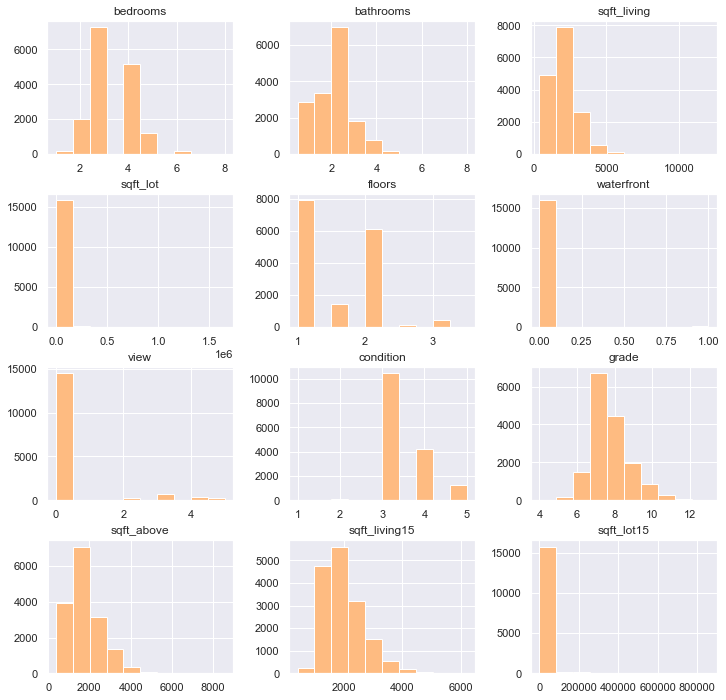

In [172]:
# Examine skew of final features
X_train[final_features].hist(figsize=(12,12));

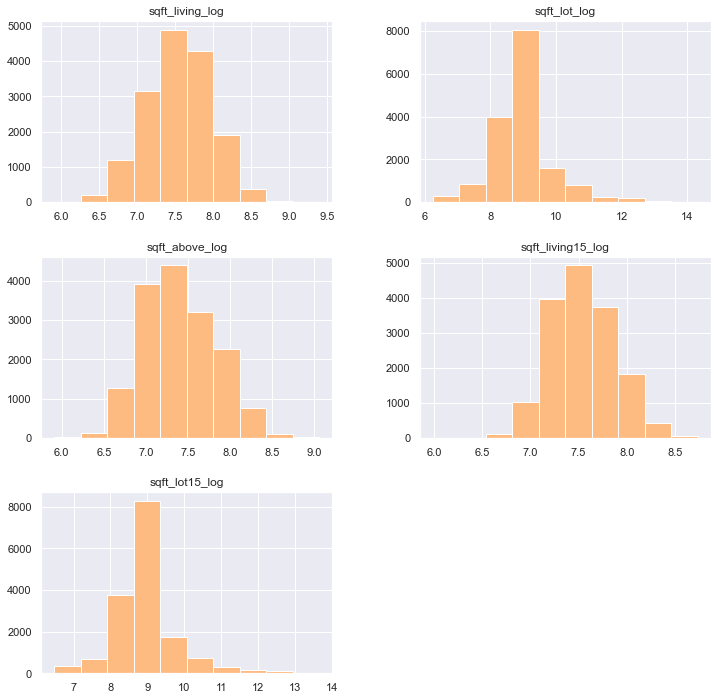

In [173]:
# Apply log to continuous features and re-examine skew
X_train_continuous_log = pd.DataFrame([])
X_train_continuous_log['sqft_living_log'] = np.log(X_train['sqft_living'])
X_train_continuous_log['sqft_lot_log'] = np.log(X_train['sqft_lot'])
X_train_continuous_log['sqft_above_log'] = np.log(X_train['sqft_above'])
X_train_continuous_log['sqft_living15_log'] = np.log(X_train['sqft_living15'])
X_train_continuous_log['sqft_lot15_log'] = np.log(X_train['sqft_lot15'])
X_train_continuous_log.hist(figsize=(12,12));

In [174]:
# Create a DataFrame of all train features (independent & target) so
# everything can be scaled
X_train_discreet = X_train[['bedrooms', 'bathrooms', 'floors', 'waterfront',
                           'view', 'condition', 'grade']]

X_train_cont_disc = pd.concat([X_train_continuous_log, X_train_discreet, y_train_log],
                              axis=1)

train_columns = X_train_cont_disc.columns

In [175]:
# Scale all training features
scaler = StandardScaler()
X_train_log_scaled = scaler.fit_transform(X_train_cont_disc)

In [176]:
# Re-separate target and independent features
X_train_full = pd.DataFrame(X_train_log_scaled, columns=train_columns)

y_train_log_scaled = X_train_full['price']
X_train_log_scaled = X_train_full.drop(columns=['price'])
X_train_log_scaled

,sqft_living_log,sqft_lot_log,sqft_above_log,sqft_living15_log,sqft_lot15_log,bedrooms,bathrooms,floors,waterfront,view,condition,grade
0,0.341342,1.621903,0.701227,0.938974,1.875538,-0.416252,0.501470,0.934720,-0.081134,-0.318588,-0.630559,1.135535
1,-1.273579,-0.131180,-0.903065,-0.676565,-0.114957,-0.416252,-1.459386,-0.916846,-0.081134,-0.318588,-0.630559,-0.563878
2,-0.381093,-0.480629,-0.016454,-0.696899,-0.499308,0.699871,-0.152149,0.008937,-0.081134,-0.318588,0.910658,-0.563878
3,-0.776776,0.232819,-0.409532,-0.717370,0.254952,-0.416252,-0.478958,-0.916846,-0.081134,-0.318588,0.910658,-0.563878
4,1.457558,0.556610,1.810095,1.752909,0.652304,1.815995,2.135517,0.934720,-0.081134,-0.318588,-0.630559,1.985242
...,...,...,...,...,...,...,...,...,...,...,...,...
16051,0.197557,-0.078363,0.558388,0.779482,-0.430305,0.699871,0.501470,0.934720,-0.081134,-0.318588,-0.630559,0.285829
16052,-0.267305,0.127210,0.096586,0.074471,0.002344,0.699871,-0.478958,-0.916846,-0.081134,-0.318588,-0.630559,-0.563878
16053,1.710955,0.510454,1.038236,1.982320,0.876369,1.815995,1.481898,0.934720,-0.081134,2.529545,0.910658,1.985242
16054,-0.864543,-1.057355,-0.496722,-1.206285,-0.785712,-1.532376,-1.459386,-0.916846,-0.081134,-0.318588,0.910658,-0.563878


In [177]:
# Repeat the above process for the testing data
X_test_continuous_log = pd.DataFrame([])
X_test_continuous_log['sqft_living_log'] = np.log(X_test['sqft_living'])
X_test_continuous_log['sqft_lot_log'] = np.log(X_test['sqft_lot'])
X_test_continuous_log['sqft_above_log'] = np.log(X_test['sqft_above'])
X_test_continuous_log['sqft_living15_log'] = np.log(X_test['sqft_living15'])
X_test_continuous_log['sqft_lot15_log'] = np.log(X_test['sqft_lot15'])

X_test_discreet = X_test[['bedrooms', 'bathrooms', 'floors', 'waterfront',
                          'view', 'condition', 'grade']]
X_test_cont_disc = pd.concat([X_test_continuous_log, X_test_discreet, y_test_log],
                              axis=1)
test_columns = X_test_cont_disc.columns

scaler2 = StandardScaler()
X_test_log_scaled = scaler2.fit_transform(X_test_cont_disc)

X_test_full = pd.DataFrame(X_test_log_scaled, columns=test_columns)

y_test_log_scaled = X_test_full['price']
X_test_log_scaled = X_test_full.drop(columns=['price'])

In [178]:
# Create, run and score final model using log and scaled data
final_model_log_scaled = LinearRegression()
final_model_log_scaled.fit(X_train_log_scaled, y_train_log_scaled)

final_model_log_scaled.score(X_test_log_scaled, y_test_log_scaled)

0.6016290701772524

In [179]:
# Find normalized-scaled RMSE
RMSE_log_scaled = mean_squared_error(y_test_log_scaled,
                   final_model_log_scaled.predict(X_test_log_scaled),
                   squared=False)
RMSE_log_scaled

0.6311663250069252

In [180]:
# Convert normalized-scaled RMSE back to USD
target_log = pd.concat([y_train_log_scaled, y_test_log_scaled], axis=0)

y_hat_train = final_model_log_scaled.predict(X_train_log_scaled)
y_hat_test = final_model_log_scaled.predict(X_test_log_scaled)

def inv_normalize_price(feature_normalized):

    mu = target_log.mean()
    sd = target_log.std()
    return sd*feature_normalized + mu

inv1 = 10**(inv_normalize_price(y_train_log_scaled))
inv2 = 10**(inv_normalize_price(y_hat_train))
inv3 = 10**(inv_normalize_price(y_test_log_scaled))
inv4 = 10**(inv_normalize_price(y_hat_test))

# Transform back to regular $USD price (not log price)
train_mse_non_log = mean_squared_error(inv1, inv2)
test_mse_non_log = mean_squared_error(inv3, inv4)

# Take the square root of MSE to find RMSE * 100 for USD units
non_log_train = round(np.sqrt(train_mse_non_log)*100, 2)
non_log_test = round(np.sqrt(test_mse_non_log)*100, 2)

print(f'Train RMSE non-log: ${non_log_train}')
print(f'Test RMSE non-log: ${non_log_test}')

Train RMSE non-log: $224153.36
Test RMSE non-log: $193722.87


#### Checking Linear Assumptions (though not as important for predictive purposes)

Linearity

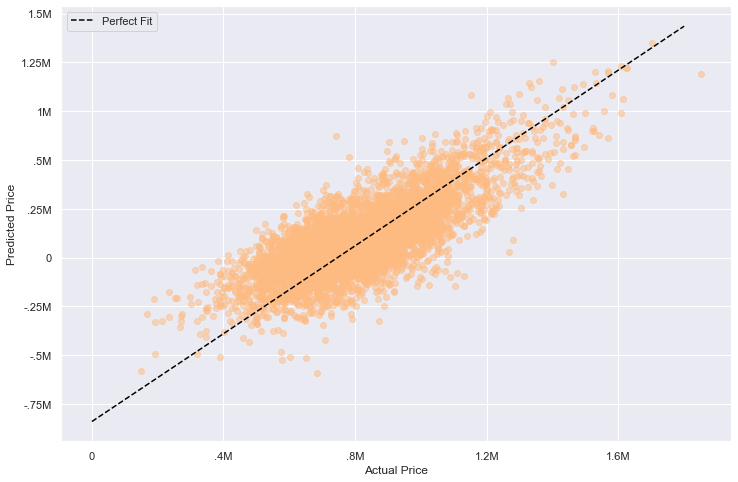

In [228]:
preds = final_model_log_scaled.predict(X_test_log_scaled)
fig, ax = plt.subplots(figsize=(12,8))
pred_xticks = ['0', '0', '.4M', '.8M', '1.2M', '1.6M']
pred_yticks = ['0', '-.75M', '-.5M', '-.25M', '0', '.25M', '.5M', '1M', '1.25M', '1.5M']
perfect_line = np.arange(y_test_log_scaled.min(), y_test_log_scaled.max(), step=.9)
ax.plot(perfect_line, linestyle="--", color="black", label="Perfect Fit")
ax.scatter(y_test_log_scaled+4.1, preds+.4, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.set_xticklabels(pred_xticks)
ax.set_yticklabels(pred_yticks)
ax.legend();

Normality

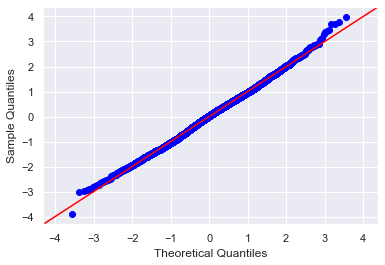

In [182]:
residuals = (y_test_log_scaled - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

Multicollinearity (Independence Assumption)

In [183]:
vif = [variance_inflation_factor(X_train_log_scaled.values, i) for i in range(X_train_log_scaled.shape[1])]
pd.Series(vif, index=X_train_log_scaled.columns, name="Variance Inflation Factor")

sqft_living_log      7.590694
sqft_lot_log         6.879479
sqft_above_log       6.508132
sqft_living15_log    2.693927
sqft_lot15_log       6.628946
bedrooms             1.840879
bathrooms            2.936694
floors               2.317990
waterfront           1.138355
view                 1.264823
condition            1.106391
grade                2.986685
Name: Variance Inflation Factor, dtype: float64

Homoscedasticity

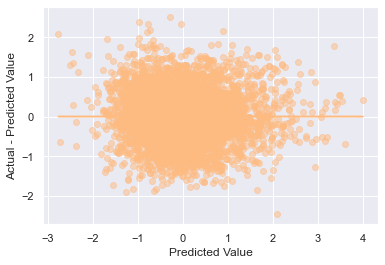

In [184]:
fig, ax = plt.subplots()
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test_log_scaled))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

## Results
***
Given the provided dataset and linear regression approach, both our inferential and predictive models did not perform as well as we had hoped.
- For the inferential model, homoscedasticity was poor, multicollinearity (VIF) was too high and the RMSE range was north of \$173k+. Linearity and normality performed decently.
- For the predictive model, multicollinearity (VIF) was too high for several features, the model score was an underwhelming .601629 and the RMSE range of \$193k+ was too great to provide any predictive value. Linearity and homoscedasticity were decent and normality was excellent, due to normalizing the data in pre-processing.

## Recommendations
***
We recommend ***not*** using our models for inferential or predictive purposes and perhaps looking into different modeling approaches other than linear regression.